In [8]:
%matplotlib inline
import numpy as np
import pandas as pd
import graphviz
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels


data = pd.read_csv(r"../data/train.csv")
del data['Id']

X = data.loc[:, data.columns != 'Cover_Type'].values
Y = data['Cover_Type'].values

data.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [11]:
# utils
def k_fold(k, X, Y):
    test_size = len(Y) // k
    selection = np.random.permutation(len(Y))
    test_x = X[selection[:test_size]]
    test_y = Y[selection[:test_size]]
    train_x = X[selection[test_size:]]
    train_y = Y[selection[test_size:]]
    return (train_x, train_y), (test_x, test_y)

from scikitplot.metrics import plot_confusion_matrix

Decision tree precision: 0.7877


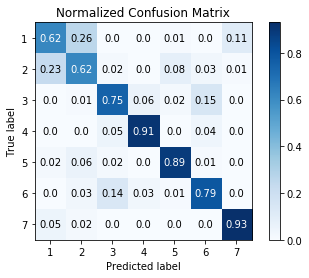

In [18]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
(train_x, train_y), (test_x, test_y) = k_fold(5, X, Y)

dtree = DecisionTreeClassifier()
dtree.fit(train_x, train_y)
print("Decision tree precision: %.4f" % (dtree.score(test_x, test_y), ))
test_y_pred = dtree.predict(test_x)

plot_confusion_matrix(test_y, test_y_pred, normalize=True)

In [74]:
from os import environ, pathsep
environ["PATH"] += pathsep + r'C:\Program Files (x86)\Graphviz2.38\bin'

dot_data = export_graphviz(dtree, out_file=None, filled=True, rounded=True, special_characters=True) 
graph = graphviz.Source(dot_data)

# graph

Naive Bayes accuracy 0.5906


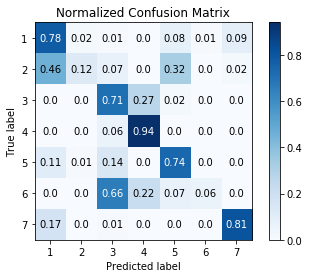

In [17]:
# naive bayes
from sklearn.naive_bayes import GaussianNB

(train_x, train_y), (test_x, test_y) = k_fold(5, X, Y)

gnb = GaussianNB()
gnb.fit(train_x, train_y)
print("Naive Bayes accuracy %.4f" % (gnb.score(test_x, test_y), ))

test_y_pred = gnb.predict(test_x)
plot_confusion_matrix(test_y, test_y_pred, normalize=True)

kNN accuracy: 0.7718


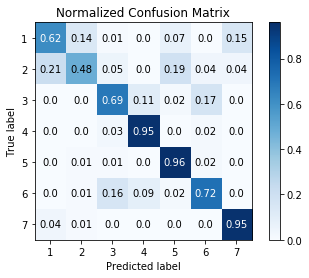

In [23]:
from sklearn.neighbors import KNeighborsClassifier

(train_x, train_y), (test_x, test_y) = k_fold(5, X, Y)

nn = KNeighborsClassifier(n_neighbors=10)
nn.fit(train_x, train_y)

print("kNN accuracy: %.4f" % (nn.score(test_x, test_y)))
test_y_pred = nn.predict(test_x)
plot_confusion_matrix(test_y, test_y_pred, normalize=True)

(15120, 7)
Epoch 1/10
12096/12096 [==============================] - 11s 885us/step - loss: 1.2199 - acc: 0.517310s - l
Epoch 2/10
12096/12096 [==============================] - 3s 216us/step - loss: 0.9542 - acc: 0.6037
Epoch 3/10
12096/12096 [==============================] - 3s 208us/step - loss: 0.8869 - acc: 0.6308
Epoch 4/10
12096/12096 [==============================] - 3s 211us/step - loss: 0.8643 - acc: 0.6401 0s - loss: 0.8662 - acc: 0.6
Epoch 5/10
12096/12096 [==============================] - 3s 232us/step - loss: 0.8350 - acc: 0.6510
Epoch 6/10
12096/12096 [==============================] - 3s 215us/step - loss: 0.8081 - acc: 0.6659
Epoch 7/10
12096/12096 [==============================] - 3s 215us/step - loss: 0.7912 - acc: 0.6734 1s -
Epoch 8/10
12096/12096 [==============================] - 3s 219us/step - loss: 0.7610 - acc: 0.6870
Epoch 9/10
12096/12096 [==============================] - 3s 225us/step - loss: 0.7555 - acc: 0.6910
Epoch 10/10
3024/3024 [===============

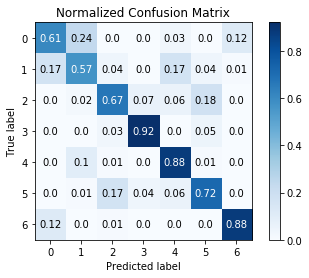

In [102]:
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, ReLU, ELU
from keras.utils import to_categorical
from sklearn.decomposition import PCA

# :10 approx 73 % accuracy on test set
# [0, 1, 2, 3, 4, 5, 9] approx 75 % accuracy on test set
# [0, 1, 2, 3, 5, 9] approx 73.5 % accuracy on test set
# [0, 1, 2, 3, 4, 5, 7, 9] approx 71 % accuracy on test set

pca = PCA(n_components=7)
_X = X[:, :10].astype(np.float64)
_X = _X.dot(pca.fit(_X).components_.T)
# _X = (_X - np.mean(_X, axis=0))

np.random.seed(10);

(train_x, train_y), (test_x, test_y) = k_fold(5, _X, Y)
classes = 7
train_y = to_categorical(train_y - 1, classes)  # label in [1, 7] => -1
test_y = to_categorical(test_y - 1, classes)  # label in [1, 7] => -1

model = Sequential([
    Dense(units=64, input_shape=(train_x.shape[1], )),
    BatchNormalization(),
    ReLU(),
    Dense(units=128),
    BatchNormalization(),
    ReLU(),
    Dense(units=64),
    BatchNormalization(),
    ReLU(),
    Dense(units=32),
    BatchNormalization(),
    ReLU(),
    Dense(units=16),
    BatchNormalization(),
    ReLU(),
    Dense(units=7, activation="softmax"),
])

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(train_x, train_y, epochs=10, batch_size=32)

print(model.evaluate(test_x, test_y, batch_size=16))
test_y_pred = model.predict(test_x)
plot_confusion_matrix(np.argmax(test_y, axis=1), np.argmax(test_y_pred, axis=1), normalize=True)